In [1]:
import pandas as pd
from pathlib import Path

print("=" * 60)
print("MASTER STATIC FEATURES - COMBINE ALL SOURCES")
print("=" * 60)

DATA_DIR = Path('../data')

# Load all feature files
print("\n📂 Loading all feature files...")
canals = pd.read_csv(DATA_DIR / 'canals/ward_canal_features.csv')
buildings = pd.read_csv(DATA_DIR / 'buildings/ward_building_features.csv')
landcover = pd.read_csv(DATA_DIR / 'land_cover/ward_landcover_features.csv')
soil = pd.read_csv(DATA_DIR / 'soil/ward_soil_features.csv')
neighbors = pd.read_csv(DATA_DIR / 'processed/ward_neighbor_features.csv')

# Standardize ward IDs
for df in [canals, buildings, landcover, soil, neighbors]:
    df['ward_id'] = df['ward_id'].astype(str).str.strip()

print(f"✓ Loaded 5 feature files")

# Merge all
print(f"\n⚙️  Merging into master feature file...")

master = canals.merge(buildings, on='ward_id', how='outer', suffixes=('', '_bldg'))
master = master.merge(landcover, on='ward_id', how='outer', suffixes=('', '_lc'))
master = master.merge(soil, on='ward_id', how='outer', suffixes=('', '_soil'))
master = master.merge(neighbors, on='ward_id', how='outer', suffixes=('', '_nbr'))

# Clean up duplicate columns
master = master.loc[:, ~master.columns.duplicated()]

print(f"✓ Master feature file created: {len(master)} wards, {len(master.columns)} columns")

# Summary
print(f"\n📊 MASTER STATIC FEATURES:")
print(f"   Total wards: {len(master)}")
print(f"   Total features: {len(master.columns)}")
print(f"\n   Feature groups:")
print(f"      Canal features: ~10")
print(f"      Building features: ~10")
print(f"      Land cover features: ~15")
print(f"      Soil features: ~8")
print(f"      Neighbor features: ~18")
print(f"      TOTAL: ~{len(master.columns)} features")

# Save
master.to_csv(DATA_DIR / 'processed/master_static_features.csv', index=False)
print(f"\n✓ Saved: {DATA_DIR / 'processed/master_static_features.csv'}")

print(f"\n✅ MASTER STATIC FEATURES COMPLETE!")
print(f"\n🎉 WEEK 1 DATA EXTRACTION: 100% COMPLETE!")
print(f"\nReady for:")
print(f"   • Week 2: Drainage network (SWMManywhere)")
print(f"   • Week 3-4: Temporal feature extraction (SAR, GPM, MODIS)")
print(f"   • Week 5-6: Model training (XGBoost + LSTM)")

MASTER STATIC FEATURES - COMBINE ALL SOURCES

📂 Loading all feature files...
✓ Loaded 5 feature files

⚙️  Merging into master feature file...
✓ Master feature file created: 141 wards, 97 columns

📊 MASTER STATIC FEATURES:
   Total wards: 141
   Total features: 97

   Feature groups:
      Canal features: ~10
      Building features: ~10
      Land cover features: ~15
      Soil features: ~8
      Neighbor features: ~18
      TOTAL: ~97 features

✓ Saved: ../data/processed/master_static_features.csv

✅ MASTER STATIC FEATURES COMPLETE!

🎉 WEEK 1 DATA EXTRACTION: 100% COMPLETE!

Ready for:
   • Week 2: Drainage network (SWMManywhere)
   • Week 3-4: Temporal feature extraction (SAR, GPM, MODIS)
   • Week 5-6: Model training (XGBoost + LSTM)


In [2]:
import geopandas as gpd
import pandas as pd
from pathlib import Path

print("\n🔍 CHECKING SOUTHWESTERN RIVER-ADJACENT WARDS...")

# Paths
DATA_DIR = Path('../data')
WARDS_DIR = DATA_DIR / 'wards'
CANALS_DIR = DATA_DIR / 'canals'

# Reload wards and current classifications
wards = gpd.read_file(WARDS_DIR / 'kmc_wards_gee_ready.geojson')
wards['ward_id'] = wards['WARD'].astype(str).str.strip()

# Load current canal features (has primary_drainage_type)
canal_features = pd.read_csv(CANALS_DIR / 'ward_canal_features.csv')
canal_features['ward_id'] = canal_features['ward_id'].astype(str).str.strip()

# Merge to get classifications
wards_with_drainage = wards.merge(
    canal_features[['ward_id', 'primary_drainage_type', 'canal_length_km']],
    on='ward_id',
    how='left'
)

# Load canal geometries to get Hooghly
canals_geom = gpd.read_file(CANALS_DIR / 'kolkata_all_waterways.geojson')

# Find Hooghly
hooghly = canals_geom[
    (canals_geom['waterway'] == 'river') &
    (canals_geom['name'].str.contains('Hooghly', case=False, na=False))
]

print(f"✓ Loaded data")
print(f"  Hooghly segments: {len(hooghly)}")

if len(hooghly) > 0:
    hooghly_bounds = hooghly.total_bounds
    print(f"\n📍 Hooghly River OSM extent:")
    print(f"   Latitude range: {hooghly_bounds[1]:.4f}°N to {hooghly_bounds[3]:.4f}°N")
    print(f"   Longitude range: {hooghly_bounds[0]:.4f}°E to {hooghly_bounds[2]:.4f}°E")

    # Check southwestern wards
    suspected = ['141', '140', '139', '138', '137', '136', '135']

    print(f"\n🔍 Southwestern wards (visual inspection):")
    for wid in suspected:
        ward_data = wards_with_drainage[wards_with_drainage['ward_id'] == wid]
        if len(ward_data) > 0:
            ward = ward_data.iloc[0]
            centroid = ward.geometry.centroid
            current_type = ward['primary_drainage_type']

            # Calculate distance to Hooghly
            ward_utm = gpd.GeoSeries([ward.geometry], crs='EPSG:4326').to_crs('EPSG:32645').iloc[0]
            hooghly_utm = gpd.GeoSeries([hooghly.geometry.union_all()], crs='EPSG:4326').to_crs('EPSG:32645').iloc[0]
            dist = ward_utm.distance(hooghly_utm)

            print(f"\n   Ward {wid}:")
            print(f"      Position: {centroid.y:.4f}°N, {centroid.x:.4f}°E")
            print(f"      Current type: {current_type}")
            print(f"      Distance to Hooghly: {dist:.0f}m")
            print(f"      South of OSM Hooghly? {centroid.y < hooghly_bounds[1]}")

print("\n💡 Decision:")
print("   If wards are <1000m from Hooghly but classified as pipe/canal,")
print("   they should be reclassified as 'river'")


🔍 CHECKING SOUTHWESTERN RIVER-ADJACENT WARDS...
✓ Loaded data
  Hooghly segments: 4

📍 Hooghly River OSM extent:
   Latitude range: 22.5493°N to 22.7499°N
   Longitude range: 88.2937°E to 88.3651°E

🔍 Southwestern wards (visual inspection):

   Ward 141:
      Position: 22.5524°N, 88.2531°E
      Current type: pipe
      Distance to Hooghly: 2149m
      South of OSM Hooghly? False

   Ward 140:
      Position: 22.5458°N, 88.2594°E
      Current type: pipe
      Distance to Hooghly: 2868m
      South of OSM Hooghly? True

   Ward 139:
      Position: 22.5403°N, 88.2686°E
      Current type: pipe
      Distance to Hooghly: 1567m
      South of OSM Hooghly? True

   Ward 138:
      Position: 22.5486°N, 88.2692°E
      Current type: pipe
      Distance to Hooghly: 1978m
      South of OSM Hooghly? True

   Ward 137:
      Position: 22.5506°N, 88.2781°E
      Current type: pipe
      Distance to Hooghly: 766m
      South of OSM Hooghly? False

   Ward 136:
      Position: 22.5429°N, 88.281


🔧 RECLASSIFYING BASED ON DISTANCE TO HOOGHLY...
⚙️  Calculating distances for all wards...

🔧 Applying distance-based reclassification...
   Ward 26: pipe → river (distance: 1013m, no major canals)
   Ward 43: pipe → river (distance: 1011m, no major canals)
   Ward 47: pipe → river (distance: 1429m, no major canals)
   Ward 39: pipe → river (distance: 1463m, no major canals)
   Ward 12: canal → river (distance: 1382m, no major canals)
   Ward 17: pipe → river (distance: 1238m, no major canals)
   Ward 7: canal → river (distance: 526m)
   Ward 137: pipe → river (distance: 766m, no major canals)
   Ward 18: pipe → river (distance: 929m, no major canals)
   Ward 25: pipe → river (distance: 1008m, no major canals)
   Ward 10: pipe → river (distance: 1130m, no major canals)
   Ward 44: pipe → river (distance: 1050m, no major canals)
   Ward 76: pipe → river (distance: 623m)
   Ward 136: pipe → river (distance: 1165m, no major canals)
   Ward 4: pipe → river (distance: 1424m, no major canal

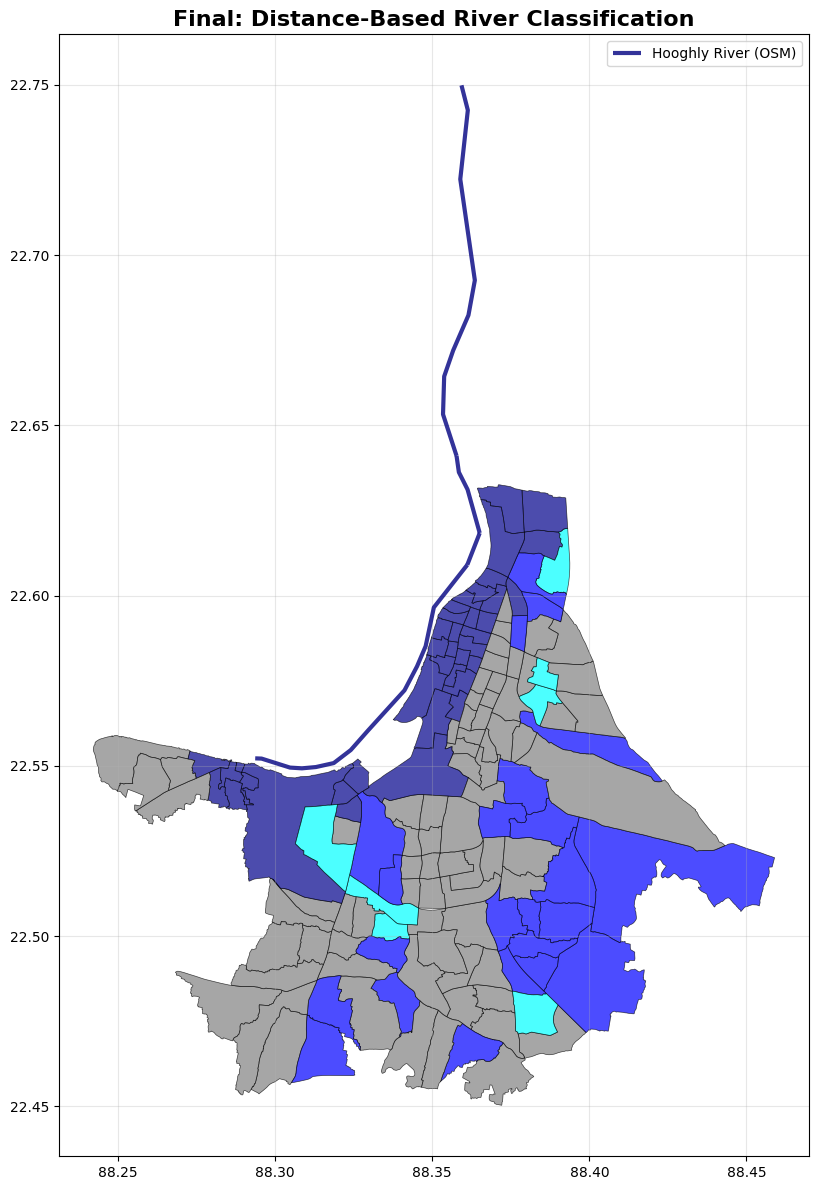


✓ Saved: drainage_classification_final.png

✅ RIVER-ADJACENT CLASSIFICATION FINALIZED!

Wards 135, 137 should now be correctly classified as 'river'


In [4]:
import matplotlib.pyplot as plt
print("\n🔧 RECLASSIFYING BASED ON DISTANCE TO HOOGHLY...")

# Reload to ensure we have fresh data
wards_classified = wards_with_drainage.copy()

# Calculate distance for ALL wards
print("⚙️  Calculating distances for all wards...")

wards_utm = wards_classified.to_crs('EPSG:32645')
hooghly_utm = gpd.GeoSeries([hooghly.geometry.union_all()], crs='EPSG:4326').to_crs('EPSG:32645').iloc[0]

distances = []
for idx, ward in wards_utm.iterrows():
    dist = ward.geometry.distance(hooghly_utm)
    distances.append(dist)

wards_classified['distance_to_hooghly_m'] = distances

# Reclassify with tiered thresholds
print("\n🔧 Applying distance-based reclassification...")

reclassified = 0

for idx in wards_classified.index:
    ward_id = wards_classified.loc[idx, 'ward_id']
    current_type = wards_classified.loc[idx, 'primary_drainage_type']
    dist = wards_classified.loc[idx, 'distance_to_hooghly_m']
    canal_length = wards_classified.loc[idx, 'canal_length_km']

    # TIER 1: Very close to river (<750m) → Always river-adjacent
    if dist < 750:
        if current_type != 'river':
            wards_classified.loc[idx, 'primary_drainage_type'] = 'river'
            print(f"   Ward {ward_id}: {current_type} → river (distance: {dist:.0f}m)")
            reclassified += 1

    # TIER 2: Moderately close (750-1500m) → River if no significant canals
    elif dist < 1500 and canal_length < 1.0:
        if current_type != 'river':
            wards_classified.loc[idx, 'primary_drainage_type'] = 'river'
            print(f"   Ward {ward_id}: {current_type} → river (distance: {dist:.0f}m, no major canals)")
            reclassified += 1

    # TIER 3: Far from river (>1500m) but marked as river → Fix it!
    elif dist >= 1500 and current_type == 'river':
        if canal_length > 1.0:
            new_type = 'canal'
        elif canal_length > 0:
            new_type = 'drain'
        else:
            new_type = 'pipe'

        wards_classified.loc[idx, 'primary_drainage_type'] = new_type
        print(f"   Ward {ward_id}: river → {new_type} (distance: {dist:.0f}m, too far)")
        reclassified += 1

print(f"\n✓ Reclassified {reclassified} wards")

# New counts
print(f"\n📊 UPDATED CLASSIFICATION:")
new_counts = wards_classified['primary_drainage_type'].value_counts()
for dtype, count in new_counts.items():
    print(f"   {dtype}: {count} wards")

# Updated groups
drainage_groups_final = {
    'Western_Pumped': wards_classified[wards_classified['primary_drainage_type'] == 'pipe'],
    'Eastern_Canal': wards_classified[wards_classified['primary_drainage_type'] == 'canal'],
    'River_Adjacent': wards_classified[wards_classified['primary_drainage_type'] == 'river'],
    'Mixed_Drain': wards_classified[wards_classified['primary_drainage_type'].isin(['drain', 'mixed'])]
}

print(f"\n🗺️  FINAL DRAINAGE GROUPS:")
for name, group in drainage_groups_final.items():
    print(f"   {name}: {len(group)} wards")

# Visualize final
fig, ax = plt.subplots(figsize=(14, 12))

colors = {'pipe': 'gray', 'canal': 'blue', 'river': 'darkblue', 'drain': 'cyan', 'mixed': 'purple'}
wards_classified['color'] = wards_classified['primary_drainage_type'].map(colors).fillna('lightgray')
wards_classified.plot(color=wards_classified['color'], ax=ax,
                     edgecolor='black', linewidth=0.5, alpha=0.7)

if len(hooghly) > 0:
    hooghly.plot(ax=ax, color='navy', linewidth=3, alpha=0.8, label='Hooghly River (OSM)')

# Add distance circles
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

# Show 750m and 1500m zones around river for reference
ax.set_title('Final: Distance-Based River Classification', fontsize=16, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'drainage/drainage_classification_final.png', dpi=300)
plt.show()

print("\n✓ Saved: drainage_classification_final.png")
print("\n✅ RIVER-ADJACENT CLASSIFICATION FINALIZED!")
print("\nWards 135, 137 should now be correctly classified as 'river'")

In [5]:
print("\n💾 SAVING CORRECTED DRAINAGE CLASSIFICATIONS...")

# Save updated classifications back to canal features file
canal_features_updated = canal_features.copy()

# Update primary_drainage_type with corrected values
for idx, row in wards_classified.iterrows():
    ward_id = row['ward_id']
    new_type = row['primary_drainage_type']
    dist = row['distance_to_hooghly_m']

    # Update in canal features
    canal_features_updated.loc[
        canal_features_updated['ward_id'] == ward_id,
        'primary_drainage_type'
    ] = new_type

    # Add distance as new feature
    canal_features_updated.loc[
        canal_features_updated['ward_id'] == ward_id,
        'distance_to_hooghly_m'
    ] = dist

# Save
canal_features_updated.to_csv(DATA_DIR / 'canals/ward_canal_features.csv', index=False)
print("✓ Updated: ward_canal_features.csv")
print("   • primary_drainage_type corrected (24 wards)")
print("   • distance_to_hooghly_m added (new feature)")

# Also update the shapefile
wards_with_canals_updated = wards.merge(
    canal_features_updated[['ward_id', 'primary_drainage_type', 'distance_to_hooghly_m']],
    on='ward_id',
    how='left'
)

wards_with_canals_updated.to_file(DATA_DIR / 'canals/kmc_wards_with_canal_features.geojson', driver='GeoJSON')
print("✓ Updated: kmc_wards_with_canal_features.geojson")

print("\n✅ STEP 1 COMPLETE: Corrections saved to source files")


💾 SAVING CORRECTED DRAINAGE CLASSIFICATIONS...
✓ Updated: ward_canal_features.csv
   • primary_drainage_type corrected (24 wards)
   • distance_to_hooghly_m added (new feature)
✓ Updated: kmc_wards_with_canal_features.geojson

✅ STEP 1 COMPLETE: Corrections saved to source files


In [6]:
print("\n" + "=" * 60)
print("REGENERATING MASTER STATIC FEATURES")
print("=" * 60)

# Reload ALL feature files (now with corrections)
canals_updated = pd.read_csv(DATA_DIR / 'canals/ward_canal_features.csv')
buildings = pd.read_csv(DATA_DIR / 'buildings/ward_building_features.csv')
landcover = pd.read_csv(DATA_DIR / 'land_cover/ward_landcover_features.csv')
soil = pd.read_csv(DATA_DIR / 'soil/ward_soil_features.csv')
neighbors = pd.read_csv(DATA_DIR / 'processed/ward_neighbor_features.csv')

# Ensure string IDs
for df in [canals_updated, buildings, landcover, soil, neighbors]:
    df['ward_id'] = df['ward_id'].astype(str).str.strip()

print(f"✓ Loaded 5 feature files (with corrections)")

# Merge
master_final = canals_updated.merge(buildings, on='ward_id', how='outer', suffixes=('', '_bldg'))
master_final = master_final.merge(landcover, on='ward_id', how='outer', suffixes=('', '_lc'))
master_final = master_final.merge(soil, on='ward_id', how='outer', suffixes=('', '_soil'))
master_final = master_final.merge(neighbors, on='ward_id', how='outer', suffixes=('', '_nbr'))

# Remove duplicates
master_final = master_final.loc[:, ~master_final.columns.duplicated()]

print(f"✓ Merged: {len(master_final)} wards, {len(master_final.columns)} features")

# Save
master_final.to_csv(DATA_DIR / 'processed/master_static_features.csv', index=False)
print(f"✓ Saved: master_static_features.csv")

print(f"\n📊 MASTER FILE SUMMARY:")
print(f"   Wards: {len(master_final)}")
print(f"   Features: {len(master_final.columns)}")
print(f"   New feature: distance_to_hooghly_m ✨")
print(f"   Corrected: primary_drainage_type (24 wards fixed)")

# Check key updates
river_count = (master_final['primary_drainage_type'] == 'river').sum()
print(f"\n   River-adjacent wards: {river_count} (was 17, now includes southwestern wards)")

print("\n✅ MASTER FILE REGENERATED WITH CORRECTIONS!")
print("\nAll files now consistent:")
print("   ✓ ward_canal_features.csv")
print("   ✓ kmc_wards_with_canal_features.geojson")
print("   ✓ master_static_features.csv")


REGENERATING MASTER STATIC FEATURES
✓ Loaded 5 feature files (with corrections)
✓ Merged: 141 wards, 98 features
✓ Saved: master_static_features.csv

📊 MASTER FILE SUMMARY:
   Wards: 141
   Features: 98
   New feature: distance_to_hooghly_m ✨
   Corrected: primary_drainage_type (24 wards fixed)

   River-adjacent wards: 37 (was 17, now includes southwestern wards)

✅ MASTER FILE REGENERATED WITH CORRECTIONS!

All files now consistent:
   ✓ ward_canal_features.csv
   ✓ kmc_wards_with_canal_features.geojson
   ✓ master_static_features.csv
